# Computational Neuroscience: Sparse coding

This implementation of [Olshausen and Field (1997)](https://www.sciencedirect.com/science/article/pii/S0042698997001697) by M Rule is inspired by and partly derived from [Takya Mamoto's](https://github.com/takyamamoto/SparseCoding-OlshausenField-Model/blob/master/sparse-coding.ipynb) notebook exploration of Olshausen and Field's paper:

> Olshausen, B. A., & Field, D. J. (1997). Sparse coding with an overcomplete basis set: A strategy employed by V1?. Vision research, 37(23), 3311-3325.

# Questions 

1. What neural computation does Olshausen and Field's whitening filter roughly correspond to?      - How would you describe the tuning curves and receptive fields of the neurons that perform this computation?
   - Where can these neurons be found?
3. Olshausen and Field's sparse dictionary learning leads to tuning curves that are localized, oriented edge filters.
   - What is the name for these cells?
   - Where can they be found in the brain?
4. This demo does not learn cells with *phase invariance*.
   - In this context, what does phase invariance mean?
   - How could you build up a neuron with a phase invariant tuning curve?
   - What is the name for cells with phase-invariant oriented edge sensitivity?
   - Where can they be found in the brain? 

# 1. Obtain datasets from http://www.rctn.org/bruno/sparsenet/

In [2]:
!wget -q "http://www.rctn.org/bruno/sparsenet/IMAGES_RAW.mat"

### Inspect image data

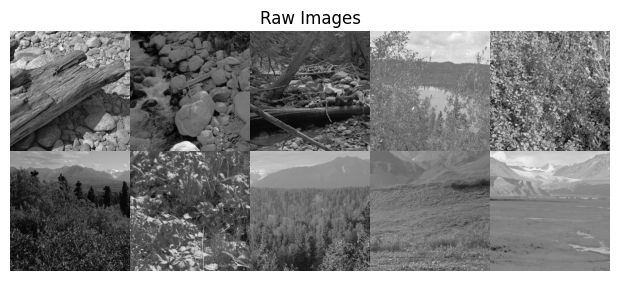

In [16]:
from pylab import *
from scipy.io     import loadmat

plt.rc('image',cmap="gray")

imsraw = float32(loadmat('IMAGES_RAW.mat')['IMAGESr']).transpose(2,0,1)
Nimages, imH, imW = imsraw.shape

fig = plt.figure(figsize=(6,2.67))
subplots_adjust(0,0,1,0.9,0,0)
for i,im in enumerate(imsraw):
    subplot(2,5,i+1); imshow(im); axis("off")
suptitle("Raw Images");

# 2. Apply centre-surround filtering to emulate Retinal Ganglion Cell (RGC) encoding

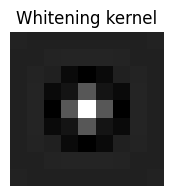

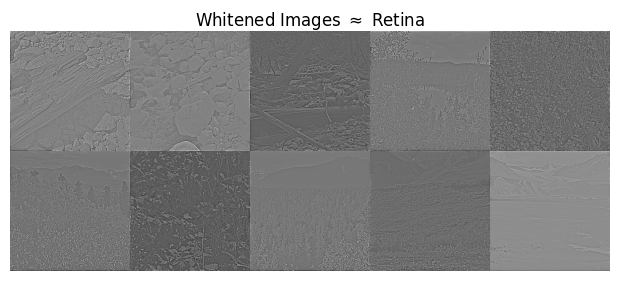

In [4]:
# This is close to the filter Olshausen and Field used
# (It's a bit ad-hoc, specifics of the frequency-
# domain construction are not on the exam.)
f2 = abs(fftfreq(imW)[:,None] + 1j*fftfreq(imH)[None,:])
whiten = ifft2(f2*exp(-(f2/(200/512))**4)).real*4

# Plot filter's "tuning curve"
# (Discussing cells with tuning like this might be on the exam)
figure(0,(2,2))
r=4
imshow((fftshift(whiten))[imW//2-r:,imH//2-r:][:2*r+1,:2*r+1])
axis('off')
title('Whitening kernel')
show()

# Apply filter to image data
def fft2_convolve(a,b):
    return ifft2(fft2(a)*fft2(b)).real
imsLGN = fft2_convolve(imsraw,whiten)
implot(imsLGN);
suptitle(r"Whitened Images $\approx$ Retina")
show()

# 3. V1 simple cells via Olshausen & Field sparse reconstruction 

### Divide images into patches

In [5]:
L = 16   # image patch size (divides 512 evenly)
N = L**2 # number of visible units
q = imW//L
assert L*q==imW
patches = imsLGN.reshape(Nimages,q,L,q,L)[:,1:-1,:,1:-1,:].transpose(0,1,3,2,4).reshape(Nimages*(q-2)**2,N)
patches = (patches - mean(patches,1)[:,None])
Npatches = len(patches)

def tuning_figure(weights):
    figure(0,(4,4/.9),120); 
    subplots_adjust(0,0,1,0.9,0.1,0.09)
    M = int(ceil(sqrt(K)))
    for i in range(K):
        subplot(M,M,1+i)
        imshow(weights[i].reshape(L,L), cmap="gray", interpolation='bicubic')
        axis('off')

### Learn sparse coding 

Epoch 500: loss 0.07050                

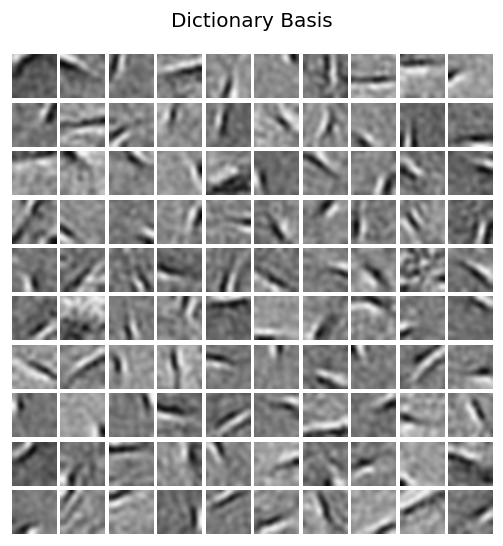

In [11]:
K  = 100  # number of hidden units
ηu = 2e-2 # learning rate for tuning curves (outer loop)
ηx = 2e-2 # learning rate for latent states (inner loop)
λ  = 0.5  # soft threshold (prox) strength (sparsity)
tol    = 1e-9 # Monvergence tolerance for inner encoding step
Ninner = 50   # Maximum encoding loop iterations
Nbatch = 250  # Batch size (patterns used to update weights)
Nepoch = 500  # Number of batches to use
W = randn(K,N).astype(float32) * sqrt(1/K) # Initial synaptic weights
for epoch in range(Nepoch):
    # Get image patches
    Y = patches[choice(arange(Npatches),Nbatch,replace=False)]
    # Normalize dictionary turning curves
    W /= maximum(norm(W, ord=2, axis=1, keepdims=True), 1e-8)
    # Encode as Y ~ XU
    X = zeros((Nbatch, K))
    for iencode in range(Ninner):
        X0 = X
        r  = Y-X@W
        X  = X + ηx*r@W.T             # Reduce reconstruction error
        X  = sign(X)*maximum(abs(X)-ηx*λ,0) # Encourage sparsity
        if mean((X-X0)**2) < tol:            
            break
    r  = Y-X@W
    W += ηu * X.T @ r # Update tuning curves
    if epoch%10==9:
        loss = mean(r**2) + λ*mean(abs(X))
        print(("\rEpoch %03d: loss %2.5f"%(epoch+1,loss)).rjust(40),flush=True,end='')

tuning_figure(W)
suptitle("Dictionary Basis");

# Save for the next part
Wsparse = W
Xsparse = X

# 5. Compare to Principle Component Analysis (PCA)

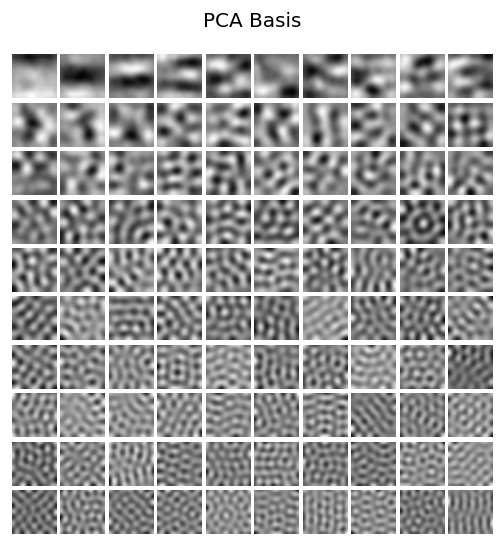

In [33]:
Σ = (patches.T@patches)/Npatches
λ,Q = eigh(Σ) #Σ=V@diag(λ)@V.T
Wpca = Q.T[argsort(-λ)][:K]
tuning_figure(Wpca)
suptitle("PCA Basis");

# 6. Gabor functions (wavelets) as filters

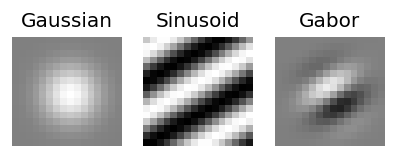

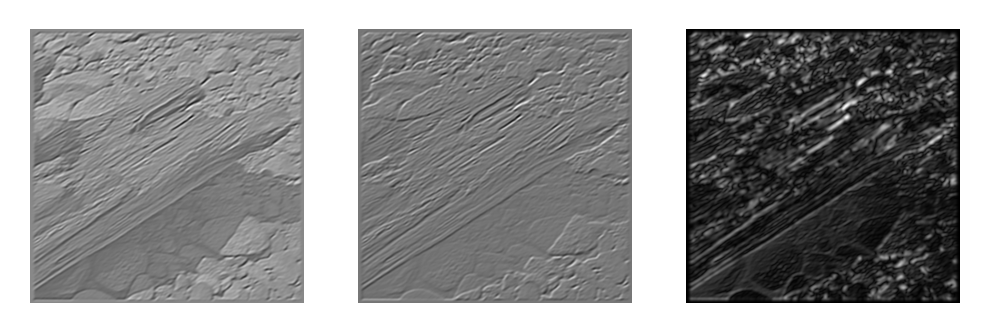

In [131]:
from scipy.signal import convolve2d

θ = 60*(pi/180)
ψ = random()*2*pi # phase
σ = L/4           # size
λ = L/2           # wavelength

l = arange(L)-L/2
px,py = array(meshgrid(l,l))
r = sqrt(px**2+py**2)

gaussian = exp(-(r/σ)**2)
planevec = (cos(θ)*px + sin(θ)*py)*(2*pi/λ) + ψ
sinusoid = cos(planevec)
gaborcos = gaussian*sinusoid
gaborsin = gaussian*sin(planevec)

figure(0,(4,2),120)
subplot(131); imshow(gaussian,vmin=-1,vmax=1); axis('off'); title("Gaussian")
subplot(132); imshow(sinusoid,vmin=-1,vmax=1); axis('off'); title("Sinusoid")
subplot(133); imshow(gaborcos,vmin=-1,vmax=1); axis('off'); title("Gabor")
show()

a = convolve2d(imsraw[0],gaborsin)
b = convolve2d(imsraw[0],gaborcos)
figure(0,(4,2),300)
subplot(131); imshow(a); axis('off');
subplot(132); imshow(b); axis('off');
subplot(133); imshow(sqrt(a**2+b**2)); axis('off');